In [1]:
import numpy as np
from dynamics_library import SampleAndHold, PendulumCartContinuous, DoubleIntegrator
from copy import copy, deepcopy
import matplotlib
import matplotlib.pyplot as plt
import zonotope_lib as ztp
import pwa_lib as pwa
import matplotlib.animation as animation
import time
import pickle

# Tool classes

In [2]:
class StateImage():
    def __init__(self, range: np.ndarray, resolution: np.ndarray):
        self.range = copy(range)
        self.resolution = copy(resolution)
        map_size = tuple((np.diff(range) / self.resolution + 1).reshape(2,).astype(int).tolist())
        self.map = np.zeros(map_size)
        self.map_size = np.array(map_size).reshape(2, 1)

    def state2image(self, range):
        relative_range = range - self.range[:, 0:1]
        return relative_range / self.resolution

    def get_patch(self, state_range):
        image_range = self.state2image(state_range)
        image_range[:, 0] = np.floor(image_range[:, 0])
        image_range[:, 1] = np.ceil(image_range[:, 1])
        image_range = np.maximum(image_range, np.zeros((2, 1)))
        image_range = np.minimum(image_range, self.map_size - 1)
        image_range = image_range.astype(int)
        if np.any(image_range[:, 0] == image_range[:, 1]):
            return None
        row_id = list(range(image_range[0, 0], image_range[0, 1] + 1))
        col_id = list(range(image_range[1, 0], image_range[1, 1] + 1))

        return self.map[np.ix_(row_id, col_id)]

    def set_patch(self, state_range, value):
        image_range = self.state2image(state_range)
        image_range[:, 0] = np.ceil(image_range[:, 0])
        image_range[:, 1] = np.floor(image_range[:, 1])
        image_range = np.maximum(image_range, np.zeros((2, 1)))
        image_range = np.minimum(image_range, self.map_size)
        image_range = image_range.astype(int)
        if np.any(image_range[:, 0] == image_range[:, 1]):
            return None
        row_id = list(range(image_range[0, 0], image_range[0, 1] + 1))
        col_id = list(range(image_range[1, 0], image_range[1, 1] + 1))

        self.map[np.ix_(row_id, col_id)] = value

class WinSetCheck():
    def __init__(self, state_range, resolution):
        self.winset = StateImage(state_range, resolution)

    def is_included(self, box: ztp.Box):
        state_range = box.get_range()
        state_patch = self.winset.get_patch(state_range)
        if state_patch is not None and np.all(state_patch > 0):
            return True
        return False

    def intersects(self, box: ztp.Box):
        state_range = box.get_range()
        state_patch = self.winset.get_patch(state_range)
        if state_patch is not None and np.any(state_patch > 0):
            return True
        return False

class FeedbackReachSetComp:
    def __init__(self, system: pwa.AffineSys, feedback_rule, input_box: ztp.Box, input_budget: float):
        assert input_budget > 0
        assert feedback_rule.shape == (input_box.ndim, system.W.ndim)
        self.system = deepcopy(system)
        self.feedback_rule = feedback_rule
        self.input_box = input_box
        self.budget = input_budget

    def __call__(self, state_box: ztp.Box, input):
        input_usage = np.abs(self.feedback_rule) @ state_box.get_bounding_box_size()
        input_usage = np.max(input_usage / self.input_box.get_bounding_box_size())
        if input_usage > self.budget:
            temp_fdb = self.budget / input_usage * self.feedback_rule
        else:
            temp_fdb = self.feedback_rule
        reachset = self.system.compute_reachable_set_cl(temp_fdb, state_box, input)
        return reachset

# Defining the system

In [3]:
f = DoubleIntegrator()
sample_time = 1
F = SampleAndHold(continuous_function=f, sample_time=sample_time, discretization_step=0.01)
input_min = -1
input_max = -input_min
input_box = ztp.Box(np.array([[input_min, input_max]]))
theta_min = -0.5
theta_max = 0.5
theta_dot_min = -0.5
theta_dot_max = 0.5
n_steps = 2
input_box_multistep = ztp.Box(np.tile(np.array([[2*input_min, 2*input_max]]), (n_steps, 1)))
state_box = ztp.Box(np.array([[theta_min, theta_max], [theta_dot_min, theta_dot_max]]))
affine_dynamics = pwa.get_affine_dynamics(F, state_box, input_box)
affine_multi_dynamics = pwa.compute_multistep_affine_dynamics(F, n_steps, state_box, input_box)
success, feedback_rule, input_usage, _ = pwa.synthesize_controller(affine_multi_dynamics, state_box, input_box,
                                                                   affine_multi_dynamics.W.get_bounding_box().minkowski_sum(0.0001*state_box),
                                                                   unbounded=True)

Using license file /home/pouria/gurobi.lic
Academic license - for non-commercial use only


# Getting the reachable sets with and without feedback

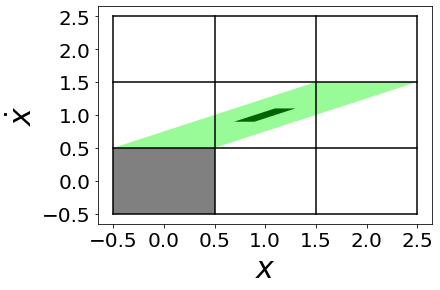

In [4]:
## Without feedback

input_list = list(np.arange(input_min, input_max+0.5, 0.5))
reachset_func = lambda x, u: affine_dynamics.compute_reachable_set(x, u)
reach_1 = reachset_func(state_box, input_list[-2])
reach_2 = reachset_func(reach_1, input_list[-2])
ztp.plot_zonotope(state_box, 'grey', fill=True)
ztp.plot_zonotope(reach_2,'palegreen', fill=True)

## With feedback
input_list = list(np.tile(np.arange(input_min, input_max + 0.5, 0.5),(n_steps,1)).T)
reachset_func = FeedbackReachSetComp(affine_multi_dynamics, feedback_rule, input_box_multistep, input_budget=0.5)
reach_2 = reachset_func(state_box, input_list[-2])
ztp.plot_zonotope(reach_2,'darkgreen', fill=True)

## Grid
for x in np.arange(-0.5,3.5,1):
    plt.plot([x, x],[-0.5, 2.5], 'k')
for y in np.arange(-0.5,3.5,1):
    plt.plot([-0.5, 2.5],[y, y], 'k')
    
plt.xlabel('$x$', fontsize=30)
plt.ylabel('$\dot{x}$', fontsize=30)
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20) 
plt.savefig('feed_vs_nofeed_reachset.pdf', bbox_inches='tight')

# Computing backward reachable set, with and without feedback

synthesis time: 30.990239143371582
synthesis time: 80.00607943534851
synthesis time: 4.891470909118652


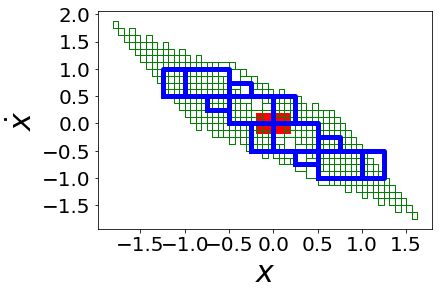

In [5]:
theta_min = -4
theta_max = 4
theta_dot_min = -4
theta_dot_max = 4
state_box = ztp.Box(np.array([[theta_min, theta_max], [theta_dot_min, theta_dot_max]]))

target = ztp.Box(np.array([[-.2, .2],[-.2, .2]]))
winning_check = WinSetCheck(state_box.get_range(), np.array([[0.01],[0.01]]))
winning_check.winset.set_patch(target.get_range(), 1)

cells = pwa.StateCell(state_box.get_range())
input_list = list(np.arange(input_min, input_max, 0.02))

check_include = winning_check.is_included
check_intersect = winning_check.intersects

reachset_func = lambda x, u: affine_dynamics.compute_reachable_set(x, u)
iterations = 2
# cells = H.state_cell.get_bare_copy()
cells = pwa.StateCell(state_box.get_range())
target_list = [target]
colors = ['g', 'y', 'k', 'r', 'b']
tot_time = time.time()
ztp.plot_zonotope(target)

    

for i in range(iterations):
    start_time = time.time()
    cells = pwa.compute_pre_rocs(reachset_func, cells, input_list, check_include, check_intersect)
    print("synthesis time: {}".format(time.time() - start_time))
    cell_list = [cells]
    while cell_list:
        cell = cell_list.pop(0)
        assert isinstance(cell, pwa.StateCell)
        if cell.is_winning:
            ztp.plot_zonotope(cell.as_box(), color='g', fill=False)
            winning_check.winset.set_patch(cell.as_box().get_range(), 1)
        elif cell.children:
            cell_list += cell.children
            
input_list = list(np.tile(np.arange(0.5*input_min, 0.5*input_max, 0.02),(n_steps,1)).T)
winning_check = WinSetCheck(state_box.get_range(), np.array([[0.01],[0.01]]))
winning_check.winset.set_patch(target.get_range(), 1)
check_include = winning_check.is_included
check_intersect = winning_check.intersects
input_box_multistep = ztp.Box(np.tile(np.array([[input_min, input_max]]), (n_steps, 1)))
reachset_func = FeedbackReachSetComp(affine_multi_dynamics, feedback_rule, input_box_multistep, input_budget=0.5)
cells = pwa.StateCell(state_box.get_range())
start_time = time.time()
cells = pwa.compute_pre_rocs(reachset_func, cells, input_list, check_include, check_intersect)
print("synthesis time: {}".format(time.time() - start_time))
cell_list = [cells]
while cell_list:
    cell = cell_list.pop(0)
    assert isinstance(cell, pwa.StateCell)
    if cell.is_winning:
        ztp.plot_zonotope(cell.as_box(), color='b', fill=False, linewidth=5)
    elif cell.children:
        cell_list += cell.children
plt.xlabel('$x$', fontsize=30)
plt.ylabel('$\dot{x}$', fontsize=30)
ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(20) 
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20) 
plt.savefig('feed_vs_nofeed_backreach.pdf', bbox_inches='tight')

<Figure size 432x288 with 0 Axes>